In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Load and prepare the MNIST dataset
transform = transforms.ToTensor()
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15197033.99it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 844816.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3939556.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8293656.41it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Define the Variational Autoencoder model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        self.fc_mu = nn.Linear(64, 32)
        self.fc_logvar = nn.Linear(64, 32)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
# Instantiate the model, define the loss function and the optimizer
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training the VAE
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in trainloader:
        inputs, _ = data
        inputs = inputs.view(-1, 28 * 28)
        outputs, mu, logvar = model(inputs)
        loss = loss_function(outputs, inputs, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(trainloader.dataset):.4f}')

Epoch [1/20], Loss: 188.9308
Epoch [2/20], Loss: 141.3391
Epoch [3/20], Loss: 127.3311
Epoch [4/20], Loss: 122.2778
Epoch [5/20], Loss: 119.3448
Epoch [6/20], Loss: 117.2786
Epoch [7/20], Loss: 115.6759
Epoch [8/20], Loss: 114.4269
Epoch [9/20], Loss: 113.5385
Epoch [10/20], Loss: 112.8250
Epoch [11/20], Loss: 112.2003
Epoch [12/20], Loss: 111.6912
Epoch [13/20], Loss: 111.0430
Epoch [14/20], Loss: 110.5991
Epoch [15/20], Loss: 110.1960
Epoch [16/20], Loss: 109.8956
Epoch [17/20], Loss: 109.5746
Epoch [18/20], Loss: 109.2991
Epoch [19/20], Loss: 109.0511
Epoch [20/20], Loss: 108.8201


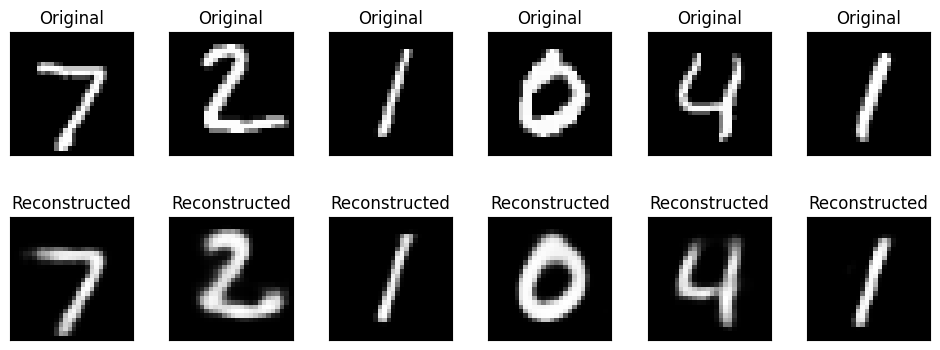

In [ ]:
# Function to visualize some results
def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        dataiter = iter(data_loader)
        images, _ = next(dataiter)  # Use next() to get the first batch of images and labels
        images = images.view(-1, 28 * 28)
        outputs, _, _ = model(images)

        # Show original and reconstructed images
        plt.figure(figsize=(12, 4))
        for i in range(6):
            ax = plt.subplot(2, 6, i + 1)
            plt.imshow(images[i].view(28, 28).cpu().numpy(), cmap='gray')
            plt.title("Original")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        for i in range(6):
            ax = plt.subplot(2, 6, i + 7)
            plt.imshow(outputs[i].view(28, 28).cpu().numpy(), cmap='gray')
            plt.title("Reconstructed")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.subplots_adjust(hspace=0.5)  # Adjust the height space between rows
        plt.show()

# Visualize some reconstructed images
visualize_reconstruction(model, testloader)